# YELP DATASET


# Goal: Using user information to improve restaurants quality


### One: Review 
> #### Is there a common theme in users' first review? If yes, what is the prevelant theme? 

### Two: Elite User Program: 

> #### a. What factors make a user become elite? ( Quality vs Quantity ) 
>
#### b. Is there a trend in users'reviews? If yes, what subtopics they usually pay attention to? 
>
#### c. How many year each user maintain the elite status? 
>
#### d. Is there any user who has quality review and/or with high quantity that does not have elite status? Does it affect there loyalty for yelp?
>
#### e. Do most people leave reviews when they travel?

### Three: Tip 
> #### Correlation between tips & reviews. What makes one to leave tips? Tips predictions.


Dataset Source: https://www.yelp.com/dataset_challenge

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation
import string
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load_ext sql

In [3]:
# !pip install ipython-sql

# Read Data

In [4]:
user = pd.read_csv('csv/user.csv')
business = pd.read_csv('csv/business.csv')
review = pd.read_csv('csv/review.csv')
tip = pd.read_csv('csv/tip.csv')

/Users/Charlotte/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# from sqlalchemy import create_engine
# engine = create_engine('sqlite:///csv.db')
# conn = engine.connect()

In [6]:
def rename_column(file):
    new_names = list()
    for col in file:
        new_names.append(col.replace('.', '_', len(col)).replace(' ', '_', len(col)).lower())
    return new_names

In [7]:
user.columns = rename_column(user.columns)
business.columns = rename_column(business.columns)
business.columns = [ re.sub('attributes_', '', c) for c in business.columns ]
review.columns = rename_column(review.columns)

In [8]:
user = user.ix[user['review_count'] != 0]
user = user.drop(['type','friends'],axis = 1 )

In [9]:
review = review.drop('type',axis = 1)
business = business.drop('type',axis = 1)
tip = tip.drop('type',axis = 1)

In [10]:
user = user.reset_index()

In [11]:
user.tail(2)

,index,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
686541,686554,2016-02,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],MAureen,uRM8uxxbhum_Bedx1c1frw,1,NaN,0,NaN,NaN,2
686542,686555,2016-04,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Amelia,DL0S4Ro4KY77akGPbEkrug,0,NaN,1,NaN,NaN,0


# Convert csv to sql database

In [11]:
# user.to_sql('user', conn)
# business.to_sql('business', conn)
# review.to_sql('review', conn)

# Data visualization

In [12]:
restaurant = business.categories.unique()

In [13]:
restaurant[0]

"['Fast Food', 'Restaurants']"

In [14]:
a = (re.search('Restaurant', restaurant[0]))
print(a)

<_sre.SRE_Match object; span=(15, 25), match='Restaurant'>


## Business Rating

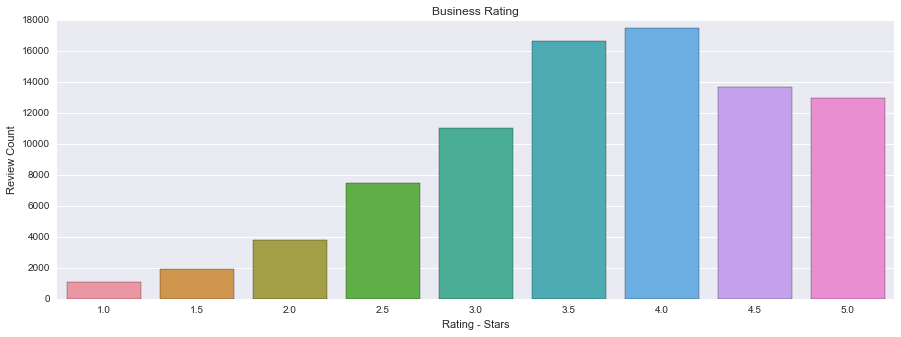

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(business['stars'])
plt.title('Business Rating')
plt.xlabel('Rating - Stars')
plt.ylabel('Review Count')

## Elite Status

In [12]:
# to find how many users in each elite year period
user['elite_year']  = [ len(i.split(',')) for i in user['elite']]

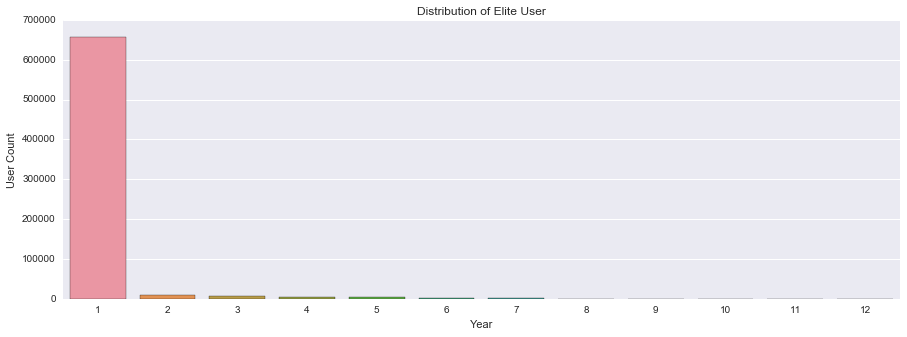

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_year'])
plt.title('Distribution of Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

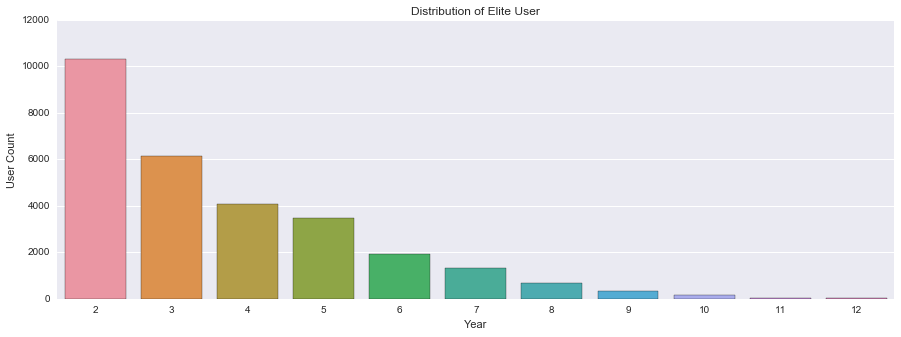

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_year'].ix[user['elite_year'] != 1])
plt.title('Distribution of Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

# Number of years since  Yelp Membership Start Year until Elite Status

In [13]:
user['elite_since'] = [i.replace('[','').replace(']','').split(',')[0] for i in user['elite']]

In [14]:
user['elite_since'] = [int(i) if i!= '' else 0 for i in user['elite_since'] ]

In [15]:
user['year_before_elite'] = [ user['elite_since'][i] - int(user['yelping_since'][i].split("-")[0]) if  user['elite_since'][i]!= 0 else 0 for i in range(686543)]

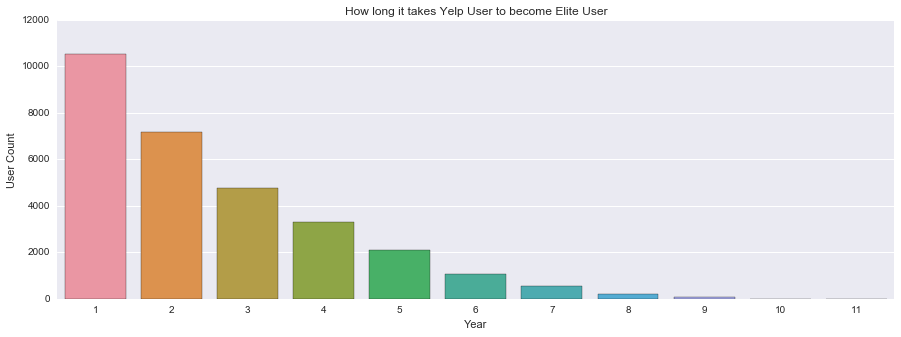

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(user['year_before_elite'].ix[user['year_before_elite']!= 0])
plt.title('How long it takes Yelp User to become Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_since'].ix[user['elite_since']!= 0])
plt.title('When user upgrade to Elite status')
plt.xlabel('Year')
plt.ylabel('User Count')

In [27]:
user['elite_since'].unique()

array([2005,    0, 2016, 2007, 2008, 2012, 2011, 2015, 2013, 2014, 2006,
       2010, 2009])

In [28]:
round((len(user) - 656772) * 100.0/ len(user),3) # percentage of elite users

4.336

In [ ]:
elite_dict = Counter(user['year_before_elite'])

In [ ]:
elite_pd = pd.DataFrame(list(elite_dict.items()),index = None,columns = ['year','user_count'])
elite_pd

In [22]:
member_since = user.groupby('yelping_since')['user_id'].count()
member_since = pd.DataFrame(member_since)

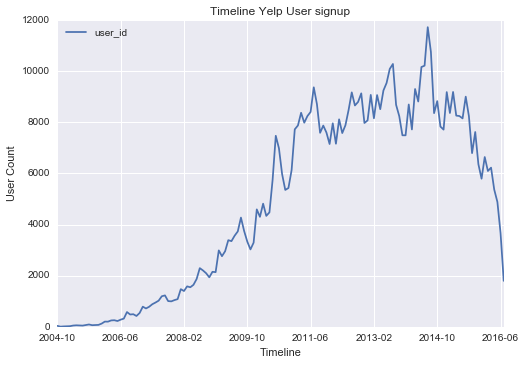

In [32]:
member_since.plot()
plt.title('Timeline Yelp User signup')
plt.xlabel('Timeline')
plt.ylabel('User Count')

# Review

In [ ]:
review.head(2)

In [16]:
a = Counter(review.user_id)
b = Counter(a.values()) # key : #review -- value: user count
b = dict(b)

In [17]:
c = pd.DataFrame(list(b.items()),index = None,columns = ['review','user_count'])
print(len(c))
c.head(2)

447


,review,user_count
0,1,360566
1,2,115750


In [18]:
c['percentage'] = [(c.user_count[i] * 100/sum(c.user_count)) for i in range(447)]

In [19]:
reviews_dict = dict()
label = ['one','two','three']
for i,label in enumerate(label):
    reviews_dict[label] = c.percentage[i]

In [20]:
reviews_dict['four_ten']= sum(c.percentage[3:10])
reviews_dict['tens']= sum(c.percentage[10:100])
reviews_dict['more_than_hundred']= sum(c.percentage[100:-1])

In [21]:
reviews_dict

{'four_ten': 15.839057556848969,
 'more_than_hundred': 0.244699631202698,
 'one': 52.518075728709675,
 'tens': 5.975477601244473,
 'three': 8.5630305466706282,
 'two': 16.859513280781176}

In [19]:
review_pd = pd.DataFrame(list(reviews_dict.items()),index = None,columns = ['review','user_percentage'])
review_pd

,review,user_percentage
0,two,16.859513
1,tens,5.975478
2,three,8.563031
3,four_ten,15.839058
4,more_than_hundred,0.244700
5,one,52.518076


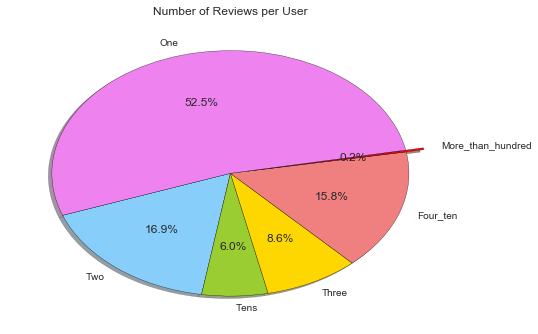

In [20]:
labels =[ i.capitalize() for i in  review_pd['review']]
sizes = review_pd['user_percentage']
colors = ['lightskyblue','yellowgreen', 'gold', 'lightcoral','red','violet']
explode = (0, 0, 0,0,.1, 0) 

plt.pie(sizes, explode=explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=200,center=(0,1));
plt.title('Number of Reviews per User')

# Filter business category to restaurant only

In [22]:
# create a dataframe with business id and category
all_businesses = pd.concat([business['business_id'], business['categories']], axis=1, keys=['business_id', 'category'])

In [23]:
all_businesses.head(3)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,UsFtqoBl7naz8AVUBZMjQQ,['Nightlife']
2,cE27W9VPgO88Qxe4ol6y_g,"['Active Life', 'Mini Golf', 'Golf']"


In [24]:
# get index of businesses that are not restaurants
not_restaurant = [i for i,e in enumerate(all_businesses.values) if "Restaurant" not in e[1]]

In [25]:
all_businesses.drop(all_businesses.index[not_restaurant], inplace=True)

In [26]:
restaurant = all_businesses # after dropping all businesses that are not restaurants 

In [27]:
restaurant = restaurant.reset_index() # reset the index 

In [28]:
restaurant = restaurant.drop('index',axis = 1) # drop the old index 

In [29]:
restaurant.head(2)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


In [30]:
# len(restaurant) # 26729 -- number of businesses
# len(restaurant.category.unique()) #4318--- number of unique categories 

In [31]:
k = Counter(restaurant.category) # 4318 -- Count number of businesses / unique category --- most categories are very similar 

In [32]:
label = [k for k,v in k.items() if v >100] # 41 --- get the label that has more than 100 businesses

In [33]:
label[:5]

["['Pizza', 'Restaurants']",
 "['Vietnamese', 'Restaurants']",
 "['Canadian (New)', 'Restaurants']",
 "['Delis', 'Restaurants']",
 "['Chicken Wings', 'Restaurants']"]

In [34]:
review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,0


In [48]:
restaurant.head(2)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


# Get Reviews for Restaurants only

In [35]:
review_indices = review['business_id'].isin(restaurant['business_id'])

In [36]:
restaurant_review = review[review_indices]

In [37]:
restaurant_review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,0


In [38]:
review_count = Counter(restaurant_review['business_id']) ### number of restaurants
print(len(review_count))
top_restaurant = [(k,v)for k,v in review_count.items() if v > 300]#number of restaurants that have more than 300 reviews
top_restaurant[:10]
sorted_by_second = sorted(top_restaurant, key=lambda tup: tup[1])
sorted_by_second[-5:]

26629


[('2e2e7WgqU1BnpxmQL5jbfw', 4103),
 ('aGbjLWzcrnEx2ZmMCFm3EA', 4149),
 ('zt1TpTuJ6y9n551sw9TaEg', 4333),
 ('sIyHTizqAiGu12XMLX3N3g', 4531),
 ('4bEjOyTaDG24SY5TxsaUNQ', 5558)]

In [39]:
sum([i[1] for i in sorted_by_second])

557659

In [33]:
business.ix[business['business_id'] == 'dcd3C1gWv-vVdQ9XYV8Ubw']

,ambience_divey,dietary_restrictions_vegan,happy_hour,hours_thursday_open,order_at_counter,hair_types_specialized_in_africanamerican,hair_types_specialized_in_kids,byob,hours_friday_open,good_for_latenight,...,noise_level,smoking,attire,hair_types_specialized_in_curly,good_for_groups,neighborhoods,open_24_hours,ambience_romantic,music_jukebox,ambience_upscale
15883,False,False,NaN,11:00,NaN,NaN,NaN,False,11:00,False,...,average,NaN,casual,NaN,True,[],NaN,False,NaN,False


In [42]:
selected_restaurants = pd.DataFrame(sorted_by_second,columns = ['business_id','review_count'])

In [44]:
selected_restaurants.tail()

,business_id,review_count
932,2e2e7WgqU1BnpxmQL5jbfw,4103
933,aGbjLWzcrnEx2ZmMCFm3EA,4149
934,zt1TpTuJ6y9n551sw9TaEg,4333
935,sIyHTizqAiGu12XMLX3N3g,4531
936,4bEjOyTaDG24SY5TxsaUNQ,5558


In [45]:
selected_restaurants.to_csv('csv/high_reviews_restaurant.csv')

In [ ]:
rating_matrix = np.zeros( shape )

In [ ]:
self.SVD_matrix = np.zeros(shape = (944, 1683), dtype = np.float32)
def modifyRatingsDataset(self): 
        ''' Assign rating values to a matrix (userid, movieid ) '''
        for index, row in self.ratings.iterrows():
            self.SVD_matrix[ int(row[0]) , int(row[1])] = float(row[2])
        return csc_matrix(self.SVD_matrix, dtype=np.float32),self.SVD_matrix

In [34]:
# def clean_the_data(x):
#     restaurant_review['text']  
    

In [35]:
restaurant_review['text']  =  [re.sub('['+string.punctuation+']', '', i.lower().replace('\n','')) for i in restaurant_review['text']]

/Users/Charlotte/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
restaurant_review['text'][0]

'mr hoagie is an institution walking in it does seem like a throwback to 30 years ago old fashioned menu board booths out of the 70s and a large selection of food their speciality is the italian hoagie and it is voted the best in the area year after year i usually order the burger while the patties are obviously cooked from frozen all of the other ingredients are very fresh overall its a good alternative to subway which is down the road'

In [37]:
def categorize_reviews(business_id):
    business_index = restaurant_review['business_id'] == business_id # get the business index
    one_restaurant = restaurant_review[business_index]
    good = one_restaurant.ix[one_restaurant['stars'] >= 3]
    bad = one_restaurant.ix[one_restaurant['stars'] < 3]
    good = good.reset_index()
    bad = bad.reset_index()
    return good.text,bad.text

In [38]:
good,bad = categorize_reviews('BVCDPqlHMDPLWn9EhdDXNg')

# Export csv file

In [40]:
restaurant.to_csv('csv/restaurant.csv')

In [41]:
restaurant_review.to_csv('csv/restaurant_review.csv')
business.to_csv('csv/new_business.csv')
review.to_csv('csv/new_review.csv')
user.to_csv('csv/new_user.csv')


In [ ]:
# listings.to_csv('data/listings_new.csv')
# reviews.to_csv('data/reviews_new.csv')
# df.to_csv('data/df_new.csv')

In [64]:
# blah = restaurant_review['business_id'] == 'dcd3C1gWv-vVdQ9XYV8Ubw' # this
# test = restaurant_review[blah]
# good = test.ix[test['stars'] >= 3]
# bad = test.ix[test['stars'] < 3]

In [227]:
def lda_topic_modeling(x):
    tfidf = TfidfVectorizer(stop_words='english')
    x = tfidf.fit_transform(x)
    lda = LatentDirichletAllocation(n_topics=15,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.)
    terms = tfidf.get_feature_names()
    lda.fit(x)
    C = lda.components_
    for topic,term in enumerate(C):
        top_indices = np.argsort(C)[topic][::-1][:10]
        term_ranking = [terms[i] for i in top_indices]
        print("Topic {}: {}".format(topic+1, ", ".join(term_ranking)))
    

In [228]:
lda_topic_modeling(good)

Topic 1: tasty, curry, fast, best, place, seats, brought, good, really, negatives
Topic 2: place, balls, reason, 11am, bells, sawtelle, toosh, gold, curry, received
Topic 3: curry, place, katsu, good, food, great, chicken, service, japanese, like
Topic 4: curry, rokkyo, appetizers, gawking, service, ratings, load, offers, spice, bit
Topic 5: shoots, scores, curry, simple, little, set, flavorful, mothers, enderloin, reasonable
Topic 6: curry, japanese, chicken, great, good, place, loved, tofu, plating, given
Topic 7: curry, love, 810ish, savory, hereactually, attentive, octopusif, elsegod, homesick, starchy
Topic 8: curry, sauce, husband, felt, normal, duration, needing, zayyumm, pho, safe
Topic 9: wanted, thingamabobs, unlv, alright, time, love, remarked, state, overallif, room
Topic 10: curry, just, right, portion, staff, best, place, highly, choice, added
Topic 11: curry, good, japanese, place, food, best, ランチで１０００円以下で食べられるところを探していたらこのyelpのサイトで評判が良い当店に決めました, 日本人の方が経営していますので安心して食べられる日

In [229]:
lda_topic_modeling(bad)

Topic 1: save, yuta, extraordinary, wrong, area, bestfriend, big, animal, great, watch
Topic 2: completely, house, 30, rainbow, told, better, got, mentioned, forced, mood
Topic 3: leave, waiting, paid, seat, sister, possible, 24hr, hot, payment, enjoy
Topic 4: ready, better, disgusted, cute, deceiving, lived, suddenly, presentable, literally, udon
Topic 5: depend, gone, dig, like, opened, clumsy, bigger, suddenly, come, beef
Topic 6: 24hr, elses, busy, reach, center, purpose, tofu, remembered, sure, awful
Topic 7: better, mediocre, trying, ordering, knows, trip, debra, did, distinguish, bad
Topic 8: serve, decided, star, away, real, does, regret, behavior, dont, croquette
Topic 9: payment, friends, later, big, wrong, mention, job, figure, told, introducing
Topic 10: brings, hurrying, big, gone, half, katsu, watery, worth, service, bowl
Topic 11: luckily, premade, paid, handed, rave, authentic, insisted, flavors, experienced, rock
Topic 12: corn, paper, different, brief, comes, animal, 

In [230]:
def nmf_tm(x):
    tfidf = TfidfVectorizer(stop_words='english')
    x = tfidf.fit_transform(x)
    nmf = NMF(init="nndsvd",
            n_components=15,
            max_iter=200)
    terms = tfidf.get_feature_names()
    nmf.fit(x)
    W = nmf.fit_transform(x)
    H = nmf.components_
    for topic,term in enumerate(H):
        top_indices = np.argsort(H)[topic][::-1][:10]
        term_ranking = [terms[i] for i in top_indices]
        print("Topic {}: {}".format(topic+1, ", ".join(term_ranking)))
    

In [231]:
nmf_tm(good)

Topic 1: just, curry, pretty, bit, little, price, small, cheese, size, okay
Topic 2: great, service, food, fast, place, little, awesome, atmosphere, wrong, coming
Topic 3: level, spicy, spice, oh, levels, time, curry, really, handle, got
Topic 4: staff, small, friendly, nice, super, place, delicious, try, absolutely, menu
Topic 5: katsu, chicken, curry, recommend, pork, favorite, definitely, vegetable, portion, takoyaki
Topic 6: good, eat, comfort, food, really, expensive, service, little, come, pretty
Topic 7: like, really, place, thing, thats, curry, didnt, ive, im, got
Topic 8: love, place, curry, food, yummy, tenderloin, traditional, glad, awesome, growing
Topic 9: amazing, time, food, come, eat, definitely, makes, coming, absolutely, feel
Topic 10: rice, cutlet, pork, brown, curry, white, sauce, time, restaurant, pickled
Topic 11: best, ive, far, places, curry, town, place, food, recommend, better
Topic 12: curry, japanese, zen, place, japan, vegas, places, real, favorite, house
T

In [226]:
nmf_tm(bad)

Topic 1: curry, ambience, fan, unfortunately, mood, isnt, kaba, tasted, big, im
Topic 2: check, didnt, ordered, location, supposed, sister, charged, checks, minutes, come
Topic 3: bowl, pork, ginger, hair, seaweed, cooked, dig, going, katsu, just
Topic 4: spice, spicy, level, adding, anymore, resemble, point, deceiving, tofu, spinach
Topic 5: required, identification, credentials, explain, depend, animals, animal, glass, card, bother
Topic 6: waitresses, worst, awful, attitude, world, bad, experience, came, minutes, wrong
Topic 7: tonkatsu, days, hard, chew, rock, ago, serve, curry, katsu, chicken
Topic 8: local, try, curry, ive, just, gas, cutlet, miles, experienced, id
Topic 9: worth, way, rice, end, make, curry, sarcasm, butt, taking, girlfriend
Topic 10: came, friends, finally, croquette, wrong, 20, ordered, food, katsu, poor
Topic 11: best, japanese, curry, thing, vegas, hypemy, townits, las, disappointed, mediocre
Topic 12: customers, line, sat, zen, order, like, table, really, c

In [223]:
# pipe_lr = Pipeline([('scl', StandardScaler()),
#    ...            ('pca', PCA(n_components=2)),
#    ...            ('clf', LogisticRegression(random_state=1))])
#    >>> pipe_lr.fit(X_train, y_train)
#    >>> print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
#    Test Accuracy: 0.947

In [170]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_good = tfidf.fit_transform(good.text)
tfidf_bad = tfidf.fit_transform(bad.text)

In [164]:
lda = LatentDirichletAllocation(n_topics=10,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

In [165]:
# lda.fit(tfidf_good)

In [166]:
lda.fit(tfidf_bad)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [167]:
terms = tfidf.get_feature_names()

In [168]:
C = lda.components_

In [169]:
for topic,term in enumerate(C):
    top_indices = np.argsort(C)[topic][::-1][:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic+1, ", ".join(term_ranking)))

Topic 1: bread, flopped, flavorless, person, sun, restaurants, reeked, smelled, crust, implication
Topic 2: grimaldis, sauce, seats, cover, destination, paltry, rarely, 20, dark, concern
Topic 3: grossed, flight, ended, likes, reeked, hype, seen, things, wineto, want
Topic 4: ended, thank, feta, drinks, rocked, wasso, 60, peaks, grill, properly
Topic 5: walking, ham, nice, able, trained, turned, dinner, bottle, yuck, favorite
Topic 6: 12, pizza, pushy, recall, really, live, menu, placed, frozen, liked
Topic 7: place, 30, disgusting, desert, crappy, pretentious, ordered, pay, didnt, handled
Topic 8: legally, like, good, money, away, great, overpriced, times, considering, politely
Topic 9: uncomfortable, garlic, friend, resolution, pleasant, eating, fruitfly, visit, shouldnt, atmosphere
Topic 10: making, recommendmany, bite, decent, dry, coffee, truly, arizona, waitressi, couple


In [138]:
nmf = NMF(init="nndsvd",
            n_components=4,
            max_iter=200)

In [139]:
nmf.fit(tfidf_bad)

NMF(alpha=0.0, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.0, max_iter=200,
  n_components=4, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [140]:
W = nmf.fit_transform(tfidf_bad)
H = nmf.components_

In [141]:
for topic,term in enumerate(H):
    top_indices = np.argsort(H)[topic][::-1][:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic+1, ", ".join(term_ranking)))

Topic 1: pizza, sauce, crust, like, cheese, just, better, oven, grimaldis, way
Topic 2: lunch, bartender, friend, talk, menus, orders, think, taking, establishment, brought
Topic 3: party, food, told, table, manager, restaurant, service, time, people, asked
Topic 4: pizza, say, really, good, place, places, nice, eat, money, visit


In [142]:
bad.text[::2]

0     most overhyped pizza in townvery crunchy overb...
2     although i have only eaten at patsy grimaldis ...
4     at about 7 pm we arrive a bunch of pilots flig...
6     tourist trap in downtown scottsdale  beau and ...
8     unfortunately i have to say i was disappointed...
10    walked in last night hoping to have a nice pie...
12    first of all i love thin crust pizza from a co...
14    i know i shouldnt look a gift horse in the mou...
16    i cant really complain too muchthe servershost...
18    so disappointed i have eaten grimaldis a few t...
20    new to the area and decided to give gremaldis ...
22    i had a calzone which was yummy but the servic...
24    omg  went here on a quiet sunday afternoon  11...
26    the food is wonderful  we continue to go month...
28    wow i expected so much better from this ny sta...
30    i have no idea why this restaurant has been ra...
32    horrible servicei came in this past saturday w...
34    crust was flavorless and limp as soon as t

## TIPS

In [14]:
len(user['elite_age'].ix[user['elite_age'] == 1])

658051

In [212]:
tip.head(2)

,user_id,text,business_id,likes,date
0,ZxdojCZgZhw36xuSGaryRg,Pizza is garbage. Hoagies are excellent.,5UmKMjUEUNdYWqANhGckJw,0,2016-07-17
1,-6rEfobYjMxpUWLNxszaxQ,Don't waste your time.,cE27W9VPgO88Qxe4ol6y_g,0,2013-04-18


In [222]:
tip_count = Counter(tip['user_id'])

In [223]:
g = pd.Series(tip_count)

In [221]:
df = pd.DataFrame({'User':g.index, 'count':g.values})

In [216]:
df.head(2)

,User,count
0,--0mI_q_0D1CdU4P_hoImQ,1
1,--2QZsyXGz1OhiD4-0FQLQ,5


In [217]:
# def ten(dl):
#     if dl > 400: return 'more_than_400'
#     elif 0 < dl <= 50: return 'under_50'
#     elif 50 < dl <= 100: return 'under_100'
#     elif 100 < dl <= 200: return 'under_200'
#     elif 200 < dl <= 300: return 'under_300'
#     elif 300 < dl <= 400: return 'under_400'
    
    
#     else: return 'None'
# f = df['count'].map(ten)

In [22]:
name = ['under_100','under_200','under_300','under_400','under_500','more_than_500']

In [23]:
# sns.countplot(x ='age_range', hue = 'sex', data = users, order=['under_100','under_200','under_300','under_400','under_500','more_than_500']);

# Create a piechart

In [164]:
# plt.pie(f, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)

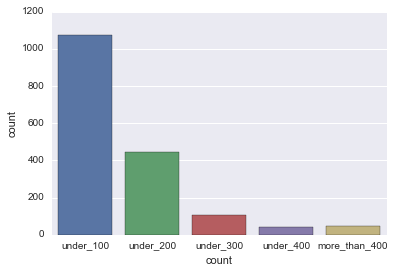

In [315]:
plt.figure(figsize=(15,5))
sns.countplot(f.ix[f != "under_50"], order =['under_100','under_200','under_300','under_400','more_than_400'] )

In [284]:
def days_late_xform(dl):
    if dl > 500: return 'more_1000'
    elif 300 < dl <= 500: return 'f'
    elif 100 < dl <= 300: return 'd'
    elif 80 < dl <= 100: return 'd'
    elif 50 < dl <= 80: return 'c'
    elif 20 < dl <= 50: return 'b'
    elif 10 < dl <= 20: return '10_20'
    elif 5 < dl <= 10: return '5_10'
    elif 2 < dl <= 3: return 'three'
    elif 1 < dl <= 2: return 'two'
    elif 0 < dl <= 1: return 'one'
    else: return 'None'

k = df['count'].map(days_late_xform)

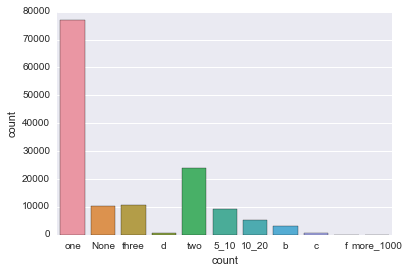

In [285]:
plt.figure(figsize=(15,5))
sns.countplot(k.ix[k != "i"])

In [246]:
# sns.lmplot("x", "y", data=c, hue='dataset', fit_reg=False)

In [204]:
# plt.figure(figsize= (10,5))
# sns.countplot(tip['user_id'])
# plt.title('Distribution of User Elite')
# plt.xlabel('Years of Elite Status')
# plt.ylabel('User Counts')